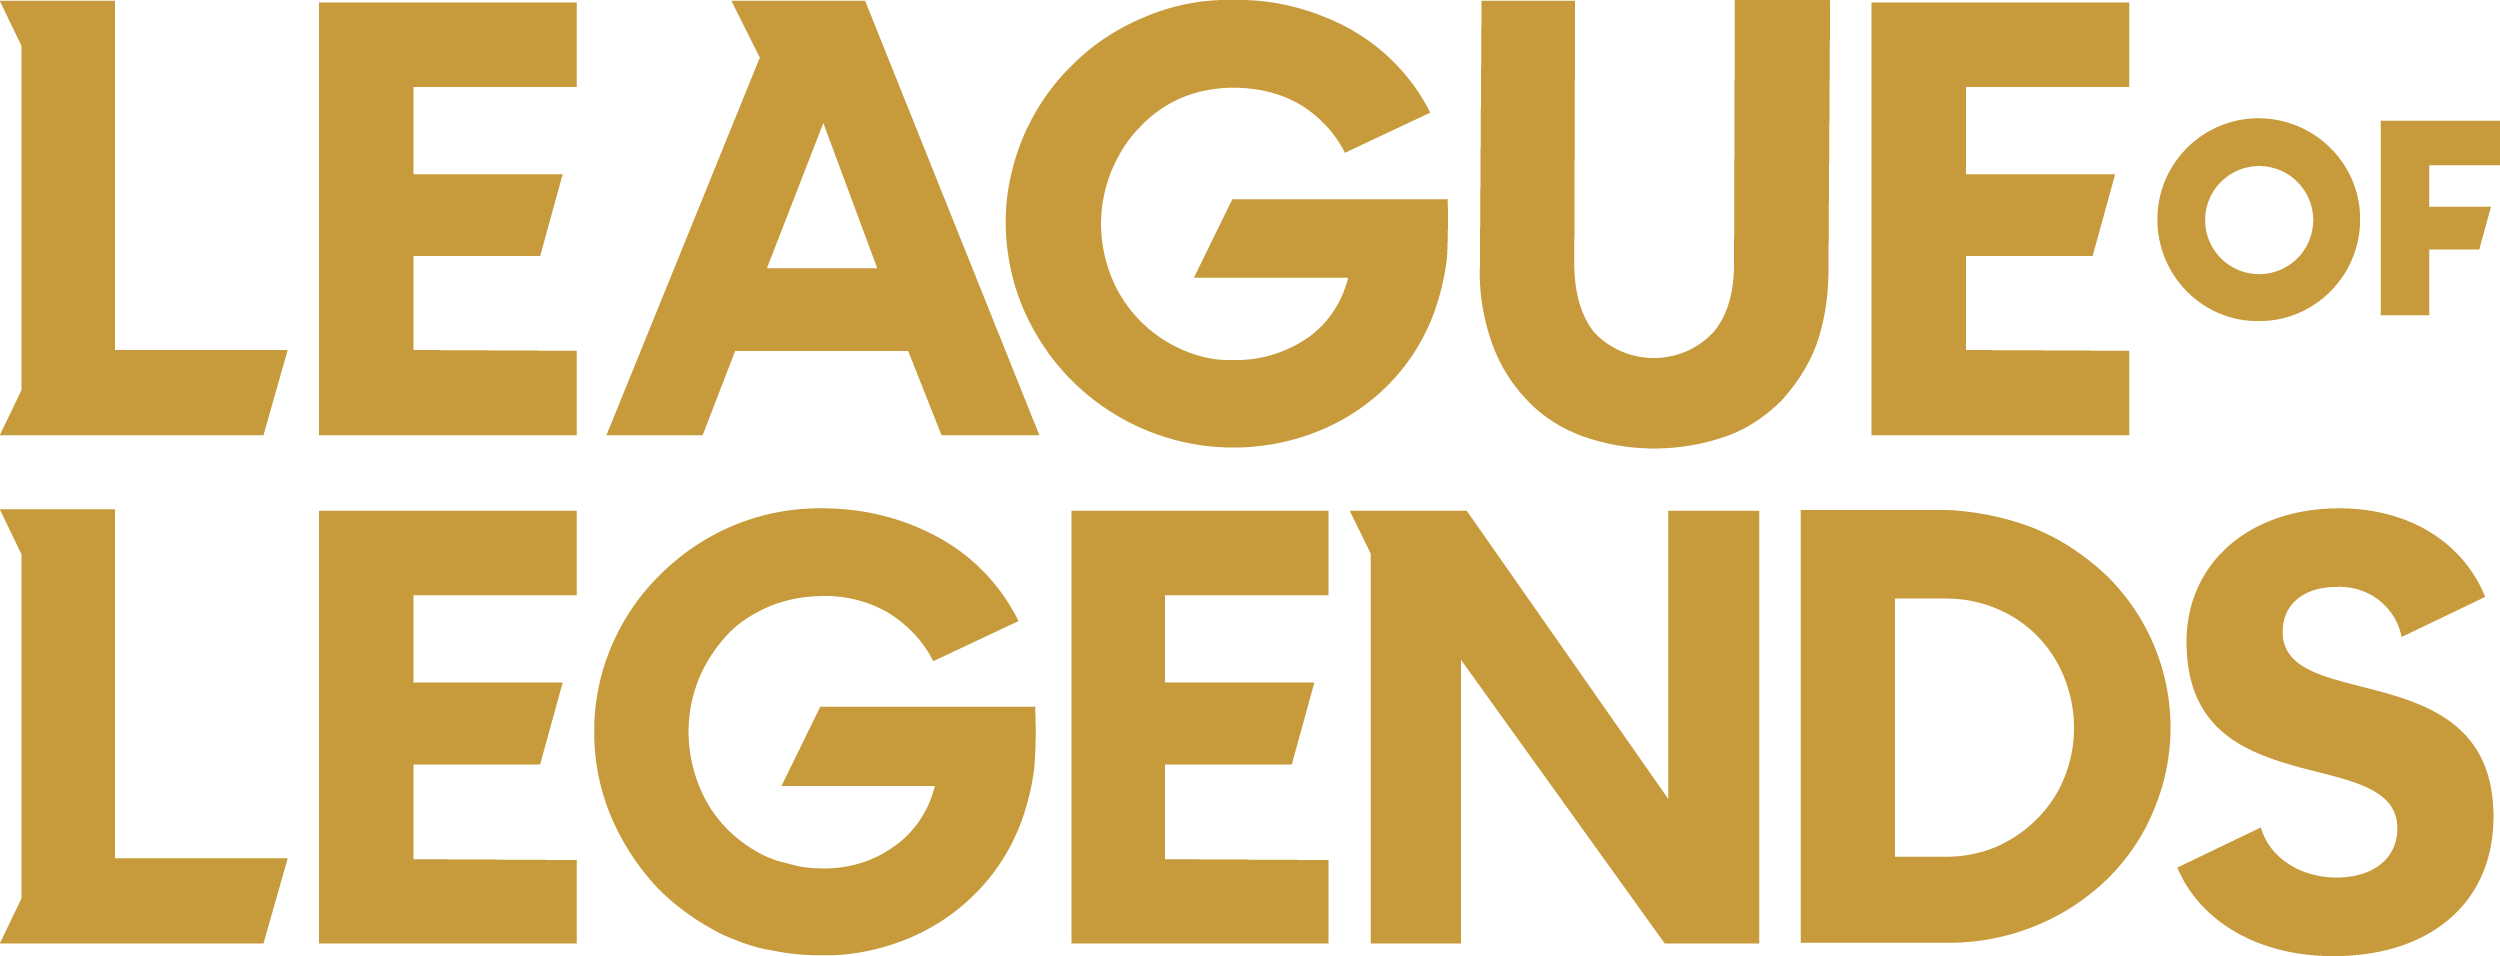

In [10]:
from IPython.display import Image
Image('data/League_of_Legends_2019_vector.png')

# Introduction
league of legends is a competitive MOBA game, where two teams
composed of 5 player's each have to win by destroying the enemy nexus "base".

in the game each player has to "kill minions/monsters/players" in order to get
gold with would result in a game advantage with would make it easier for the team to win.

# Data
This project uses 10-minutes of data collected from over twenty-six-thousand unique league of legends games.

the games were collected from high-elo players, a.k.a the top 0.01% players in the game.
the data contains stats like gold per team,
kills, dragon kills, tower destroyed, minion killed and so on...

# Purpose
we will try to predict with team would win based on the first 10 minutes of the game,
our assumption is that the team with most kill's, gold would most likely win.
<br> we will test that assumption.

### Import required Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## data overview

In [15]:
league = pd.read_csv('data/league_f10min_data.csv')
league.head()

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,...,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,4247263043,0,14870,2889,32,6.4,199,53,0,3,...,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,4247155821,1,14497,2617,33,6.6,229,44,0,2,...,[],0,0,0,0,0,0,[],0,0
2,4243963257,0,15617,1757,34,6.8,223,39,0,3,...,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,4241678498,0,15684,1439,35,7.0,251,64,0,3,...,[],0,0,0,0,0,0,[],0,0
4,4241538868,1,17472,3512,35,7.0,257,46,0,7,...,[],0,0,0,0,0,0,[],0,0


#### we can see a summary of the data by using info.

In [18]:
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26409 entries, 0 to 26408
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gameId                      26409 non-null  int64  
 1   blueWins                    26409 non-null  int64  
 2   blueTotalGolds              26409 non-null  int64  
 3   blueCurrentGolds            26409 non-null  int64  
 4   blueTotalLevel              26409 non-null  int64  
 5   blueAvgLevel                26409 non-null  float64
 6   blueTotalMinionKills        26409 non-null  int64  
 7   blueTotalJungleMinionKills  26409 non-null  int64  
 8   blueFirstBlood              26409 non-null  int64  
 9   blueKill                    26409 non-null  int64  
 10  blueDeath                   26409 non-null  int64  
 11  blueAssist                  26409 non-null  int64  
 12  blueWardPlaced              26409 non-null  int64  
 13  blueWardKills               264

#### it seems there is no null values but let's run the following line to be sure.

In [27]:
league.isna().values.any()

False

# cleanup

#### next lets remove any duplicate game's so first lets see if there is any duplicates

In [23]:
number_of_unique = len(league["gameId"].unique())
number_of_entries = league.shape[0]
print("number of entries:", number_of_entries, "number of unique entries:", number_of_unique)

number of entries: 26409 number of unique entries: 26354


#### we can see that there is some duplicate games, so lets remove those duplicates

In [26]:
league = league.drop_duplicates('gameId', keep='first').reindex()
print("number of entries:", league.shape[0], "number of unique entries:", len(league["gameId"].unique()))

number of entries: 26354 number of unique entries: 26354


#### next i will remove gameId as clearly that column shouldn't have any outcome on who wins.

In [16]:
league2 = league.drop(["gameId"], axis=1)
league2

,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,...,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,0,14870,2889,32,6.4,199,53,0,3,9,...,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,1,14497,2617,33,6.6,229,44,0,2,3,...,[],0,0,0,0,0,0,[],0,0
2,0,15617,1757,34,6.8,223,39,0,3,11,...,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,0,15684,1439,35,7.0,251,64,0,3,4,...,[],0,0,0,0,0,0,[],0,0
4,1,17472,3512,35,7.0,257,46,0,7,5,...,[],0,0,0,0,0,0,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,0,16762,5072,36,7.2,206,52,0,7,5,...,[],0,0,0,0,0,1,['WATER_DRAGON'],1,1
26405,0,35765,1440,39,7.8,191,16,0,18,27,...,[],3,1,0,2,0,0,[],0,0
26406,0,15712,4137,34,6.8,218,55,0,3,0,...,[],0,0,0,0,0,0,[],0,0
26407,1,15850,3220,33,6.6,193,48,0,6,4,...,[],0,0,0,0,0,0,[],0,0


### First try